# Use skorch to do random Hyperparameter search for 5G RNA-seq data (single-task)
Given data that has been transformed into log-ratio TPMs, search the hyperparameter spaces of various models
* Linear model
* Kmer count model
* CNN model
* CNN + LSTM model

## *** Log(TPM) 

In [169]:
import torch
from torch import nn
from torch.nn import functional as F

import optuna
from optuna.trial import TrialState

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy

import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [6]:
from skorch import NeuralNetRegressor


## Load 5G data

In [7]:
locus_info_filename = 'data/locus2info.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
locus2info = u.make_info_dict(locus_info_df)

log_data_filename = "data/XY_logTPM_opFilt.tsv"
XY_log = pd.read_csv(log_data_filename,sep='\t')

display(XY_log.head())

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.701712,5.159314,4.946232,4.544309,5.470820,5.489315,5.580793,5.425377,6.017577,5.002269,5.148210,5.063677
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.906680,5.431592,5.067489,4.241518,5.897951,6.022614,6.305779,5.935676,6.629400,5.448133,5.385163,5.449226
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,5.085045,4.772192,4.208764,4.205855,4.821135,4.878684,5.067555,4.849435,5.487238,4.416274,4.367689,4.534353
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,5.604311,5.064503,4.983838,4.084119,5.639215,5.606737,5.604730,5.671486,6.282482,5.381454,5.098383,5.404872
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.766245,4.767261,3.688497,3.422344,4.763636,4.687598,4.858654,4.698693,4.286940,4.525268,5.031830,5.103249


In [8]:
loc2seq = dict([(x,z) for (x,z) in XY_log[['locus_tag','upstream_region']].values])

print(locus2info['EQU24_RS19315'])
print(loc2seq['EQU24_RS19315'])

{'gene': 'pmoC', 'product': 'methane monooxygenase/ammonia monooxygenase subunit C', 'type': 'CDS'}
ATCAGGTTATTTTTTGGCATTGCTATGATCGAAATGGAATGAAAATGATCCGAAAAACAGGCTTTTGTAAGCAACCGATAAATAAGAGGTTAAGGGCTGGAAGATAAATGAAAATCAGGGTGGATAAAGAACTAATGATTAATAGCGCACTAGATCGGTCATAAATTAAGTTGACAAGCCTTTTCGAAATGATAAACTGAGCAGCACCAAATTGGACTGGTAGAGCTTAAATAAAAGCGTTAAAGGGATGTTTTAAAACAACCGCCCTTCGGGGTTTTTAAAAATTTTTTAGGAGGTAGA


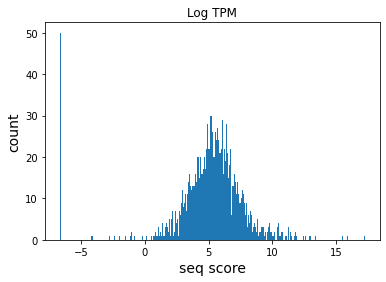

In [9]:
plt.hist(XY_log['highCu'].values,bins=500)
plt.title("score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.title("Log TPM")
plt.show()

In [10]:
for df in [XY_log]:
    df['gene'] = df['locus_tag'].apply(lambda x: locus2info[x]['gene'])
    df['product'] = df['locus_tag'].apply(lambda x: locus2info[x]['product'])


In [11]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,title,val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,test_df,val_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=['locus_tag','set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()

## Load 5G seqs into data loaders

In [12]:
# LOG
log_full_train_df,log_test_df = tu.quick_split(XY_log)
log_train_df, log_val_df = tu.quick_split(log_full_train_df)

print(log_full_train_df.shape)
print(log_test_df.shape)
print(log_train_df.shape)
print(log_val_df.shape)

assert(log_train_df.shape[0] + log_val_df.shape[0] == log_full_train_df.shape[0])

(1763, 18)
(441, 18)
(1410, 19)
(353, 19)


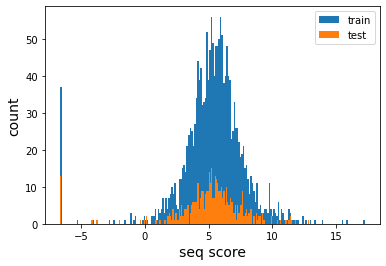

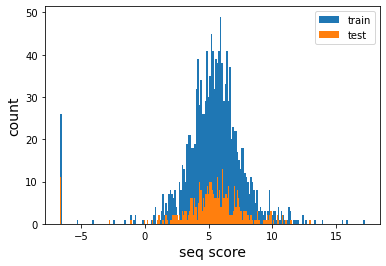

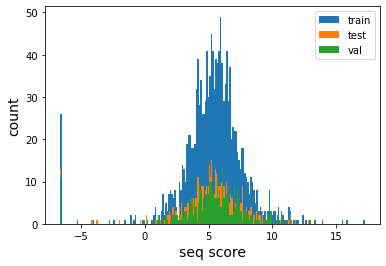

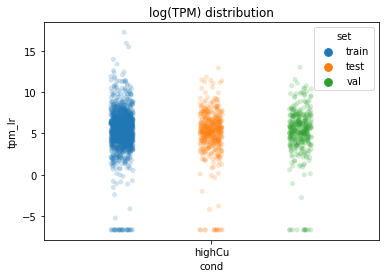

In [13]:
plot_train_test_hist(log_full_train_df, log_test_df,score_col='highCu',bins=200)
plot_train_test_hist(log_train_df, log_val_df,score_col='highCu',bins=200)

plot_train_test_hist(log_train_df, log_test_df, val_df=log_val_df,score_col='highCu',bins=200)
view_train_test_dist(log_train_df, log_test_df,["highCu"],"log(TPM)",val_df=log_val_df)


In [14]:
dataset_types = [
    DatasetSpec('ohe'),
    DatasetSpec('kmer',k=3),
    DatasetSpec('kmer',k=6),
]

In [15]:
# Dfs for the full train/test split
log_final_dls = tu.build_dataloaders_single(
    log_full_train_df, 
    log_test_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='highCu')

# Dfs from further spliting train into train and val
log_dls = tu.build_dataloaders_single(
    log_train_df, 
    log_val_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='highCu'
)

log_kmer6_train_dl,log_kmer6_val_dl = log_dls['kmer_6']
log_kmer3_train_dl,log_kmer3_val_dl = log_dls['kmer_3']
log_ohe_train_dl,log_ohe_val_dl = log_dls['ohe']

In [16]:
len(log_kmer6_train_dl.dataset.kmers)

4096

In [17]:
log_ohe_train_dl

## define basic single task models

In [18]:
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=5,
                 num_fc_nodes1=100,
                 num_fc_nodes2=10
                ):
        super().__init__()
        self.seq_len = seq_len
        self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            #nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(self.lin_nodes, num_fc_nodes1),
            nn.Linear(num_fc_nodes1, num_fc_nodes2),
            #nn.ReLU(inplace=True),
            nn.Linear(num_fc_nodes2, 1),
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

## training loop defs

In [19]:
def quick_seq_pred(model, seqs, oracle):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        actual = oracle[dna]
        diff = actual - pred.item()
        print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")

    
def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)

    xb_out = model(xb.float())
    if verbose:
        print("model out pre loss", xb_out.shape)
    loss = loss_func(xb_out, yb.float())

    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)

def train_step(model, train_dl, loss_func, opt):
    '''
    Execute 1 set of batch training for an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    # collect train loss; provide opt so backpropo happens
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(DEVICE),yb.to(DEVICE)

        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        tl.append(t)
        ns.append(n)
        
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    return train_loss

def val_step(model, val_dl, loss_func):
    '''
    Execute 1 set of batch validation for an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(DEVICE),yb.to(DEVICE)

            v, n = loss_batch(model, loss_func, xb, yb)
            vl.append(v)
            ns.append(n)

    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    return val_loss
    
def fit(epochs, model, loss_func, opt, train_dl, val_dl):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loops through epochs
    for epoch in range(epochs):
        train_loss = train_step(model, train_dl, loss_func, opt)
        train_losses.append(train_loss)
        
        
        val_loss = val_step(model, val_dl, loss_func)
        print(epoch, val_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

def run_model(train_dl,test_dl, model, lr=0.01, epochs=20):
    '''
    Given data and a model type, run dataloaders with MSE loss and SGD opt
    '''
    # define loss func and optimizer
    loss_func = torch.nn.MSELoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
    # run the training loop
    train_losses, test_losses = fit(epochs, model, loss_func, optimizer, train_dl, test_dl)
    
    #return model, train_losses, test_losses
    return train_losses, test_losses

def quick_loss_plot_simple(data_label_list,loss_type="MSE Loss",sparse_n=0):
    '''
    For each train/test loss trajectory, plot loss by epoch
    '''
    for i,((train_data,test_data),label) in enumerate(data_label_list):
        # plot only 1 in every sparse_n points
        if sparse_n:
            train_data = [x for i,x in enumerate(train_data) if (i%sparse_n==0)]
            test_data = [x for i,x in enumerate(test_data) if (i%sparse_n==0)]
            
        plt.plot(train_data,'--',color=f"C{i}", label=f"{label} Train")
        plt.plot(test_data,'o-',color=f"C{i}", label=f"{label} Test",linewidth=3.0)
        

    plt.legend()
    plt.ylabel(loss_type)
    plt.xlabel("Epoch")
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()

In [20]:
seq_len = len(log_train_df['upstream_region'].values[0])
model_cnn = DNA_CNN(
    seq_len,
    num_filters=128,
    kernel_size=8,
    num_fc_nodes1=10
)
model_cnn.to(DEVICE)

train_losses_cnn, \
test_losses_cnn = run_model(
    log_ohe_train_dl, 
    log_ohe_val_dl, 
    model_cnn, 
    lr=0.0001,
    epochs=100,
)

# to plot loss
cnn_data_label = [((train_losses_cnn,test_losses_cnn),'CNN(my fit)')]


0 18.98429919234754
1 11.663431081150476
2 9.584059915191391
3 8.792903835307438
4 8.74184479321704
5 8.829617823149597
6 8.804099734038875
7 8.812611101707049
8 8.720778989386625
9 8.714718845680821
10 8.711940593827547
11 8.723349826531775
12 8.764318687719934
13 8.776885966065922
14 8.738237579551027
15 8.753816431710133
16 8.685087967189109
17 8.679502276455715
18 8.676697622952988
19 8.652666833515546
20 8.655763368093258
21 8.814632360388131
22 8.744140916775711
23 8.682826015159023
24 8.641826948430653
25 8.644430907522315
26 8.645871221850344
27 8.645667159861276
28 8.717805316698112
29 8.647835924672675
30 8.687512755731685
31 8.607852045604933
32 8.60122972439774
33 8.648491729757941
34 8.659244446849012
35 8.671675259263251
36 8.625371969455362
37 8.6316200572438
38 8.596042508781801
39 8.55413944930598
40 8.72376916631423
41 8.585373412448353
42 8.534082335723358
43 8.548625059911279
44 8.547433404679339
45 8.540545903927207
46 8.513242664823451
47 8.506678873013504
48 8.51

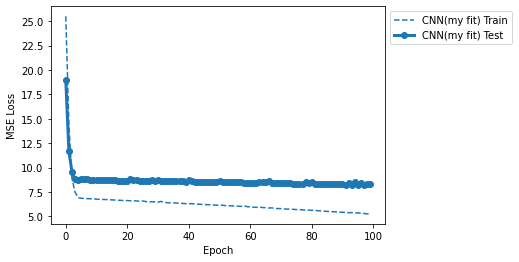

In [21]:
quick_loss_plot_simple(cnn_data_label)


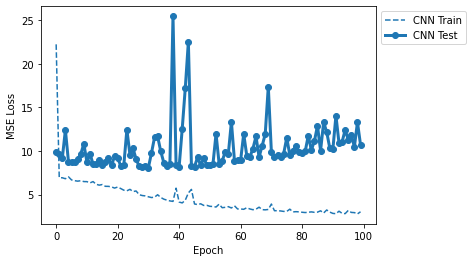

In [101]:
quick_loss_plot_simple(cnn_data_label)


## try fitting with skorch instead

In [22]:
def make_skorch_dfs(df,seq_col='seq',target_col='score'):
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
    
    return ohe_seqs.float(), labels.float()

In [153]:
log_val_df.shape

(353, 20)

In [23]:
X, y = make_skorch_dfs(log_train_df, seq_col='upstream_region',target_col='highCu')

In [24]:
X.shape

torch.Size([1410, 300, 4])

In [25]:
y.shape

torch.Size([1410, 1])

In [27]:
net_regr = NeuralNetRegressor(
    DNA_CNN,
    module__seq_len=300,
    max_epochs=100,
    lr=0.001,
    device='cuda',  # uncomment this to train with CUDA
)

In [28]:
net_regr.fit(X, y)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       19.4614        7.5740  0.0398
      2        6.9429        7.0586  0.0359
      3        6.8010        7.0325  0.0397
      4        6.7507        7.0068  0.0357
      5        6.7009        6.9815  0.0349
      6        6.6515        6.9565  0.0351
      7        6.6023        6.9315  0.0353
      8        6.5529        6.9067  0.0387
      9        6.5034        6.8817  0.0387
     10        6.4534        6.8567  0.0388
     11        6.4029        6.8316  0.0385
     12        6.3516        6.8062  0.0385
     13        6.2995        6.7805  0.0381
     14        6.2463        6.7544  0.0380
     15        6.1919        6.7280  0.0380
     16        6.1363        6.7012  0.0380
     17        6.0791        6.6739  0.0381
     18        6.0204        6.6461  0.0379
     19        5.9600        6.6178  0.0381
     20        5.8978        6.5891  0.0381
     21        5.8337        6.5

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_CNN(
    (conv_net): Sequential(
      (0): Conv2d(1, 31, kernel_size=(4, 5), stride=(1, 1))
      (1): Flatten()
      (2): Linear(in_features=9176, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=10, bias=True)
      (4): Linear(in_features=10, out_features=1, bias=True)
    )
  ),
)

In [77]:
y_pred = net_regr.predict(X[:5])
y_pred = torch.tensor(y_pred).to(DEVICE)


In [52]:
y[:5]

tensor([[6.3058],
        [5.0676],
        [4.8587],
        [3.1898],
        [6.1526]])

In [78]:
net_regr.get_loss(y_pred, y[:5])

tensor(1.7711, device='cuda:0')

In [70]:
y[:5]

tensor([[6.3058],
        [5.0676],
        [4.8587],
        [3.1898],
        [6.1526]])

In [74]:
torch.tensor(y_pred)

tensor([[5.5694],
        [6.4651],
        [4.6539],
        [5.4943],
        [5.1487]])

In [80]:
net_regr.train_split

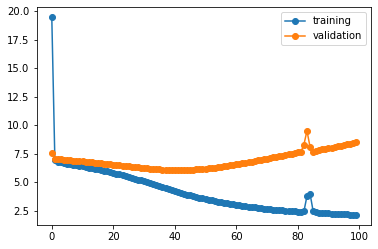

In [29]:
train_loss = net_regr.history[:, 'train_loss']
valid_loss = net_regr.history[:, 'valid_loss']

plt.plot(train_loss, 'o-', label='training')
plt.plot(valid_loss, 'o-', label='validation')
plt.legend()
plt.show()

In [85]:
len(net_regr.history)

100

In [98]:
skorch_label = [((net_regr.history[:, 'train_loss'], net_regr.history[:, 'valid_loss']), 'CNN')]

## now try random search with some params

In [68]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform,uniform
from random import randint


In [87]:
net_search = NeuralNetRegressor(
    DNA_CNN,
    module__seq_len=300,
    max_epochs=100,
    #lr=0.001,
    device='cuda',  # uncomment this to train with CUDA
)

In [88]:
params = {
    'lr': loguniform(0.00001, 0.001),#[0.001, 0.0001],#loguniform(0.0001, 0.01)
    
    'module__num_filters': [16,32,64,128], # uniform(8,128), #
    'module__kernel_size': [4,8,16,32],
    'module__num_fc_nodes1': [10, 25, 50,100], #randint(10,100), #
    'optimizer':[torch.optim.SGD, torch.optim.Adam, torch.optim.Adagrad,torch.optim.AdamW,torch.optim.RMSprop]
    #'optimizer__nesterov': [False, True],
}

In [89]:
#loguniform(0.0001, 0.01)
#u = uniform(4,12)


In [90]:
search = RandomizedSearchCV(
    net_search, 
    params, 
    n_iter=500, 
    #scoring='neg_mean_absolute_error', 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    cv=3,#cv, 
    random_state=1,
    verbose=2
)

In [91]:
search.fit(X,y)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 27.6min


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       34.5594       31.4657  0.0357
      2       28.2378       24.2876  0.0291
      3       20.0651       15.0612  0.0291
      4       11.4571        8.5411  0.0284
      5        7.4127        7.1325  0.0284
      6        6.7878        7.0255  0.0283


[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 28.5min finished


      7        6.7346        7.0139  0.0290
      8        6.7183        7.0070  0.0313
      9        6.7040        7.0004  0.0321
     10        6.6899        6.9939  0.0323
     11        6.6759        6.9875  0.0321
     12        6.6619        6.9810  0.0283
     13        6.6480        6.9746  0.0331
     14        6.6340        6.9682  0.0326
     15        6.6201        6.9618  0.0320
     16        6.6062        6.9555  0.0325
     17        6.5923        6.9491  0.0323
     18        6.5784        6.9428  0.0322
     19        6.5645        6.9365  0.0330
     20        6.5506        6.9302  0.0327
     21        6.5367        6.9238  0.0321
     22        6.5228        6.9175  0.0320
     23        6.5088        6.9113  0.0322
     24        6.4949        6.9050  0.0327
     25        6.4809        6.8987  0.0278
     26        6.4669        6.8924  0.0279
     27        6.4528        6.8861  0.0285
     28        6.4387        6.8798  0.0282
     29        6.4246        6.8

RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.DNA_CNN'>,
  module__seq_len=300,
),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'lr': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7efdbfb23210>,
                                        'module__kernel_size': [4, 8, 16, 32],
                                        'module__num_fc_nodes1': [10, 25, 50,
                                                                  100],
                                        'module__num_filters': [16, 32, 64,
                                                                128],
                                        'optimizer': [<class 'torch.optim.sgd.SGD'>,
                                                      <class 'torch.optim.adam.Adam'>,
                                                      <class 'torch.optim.adagrad.Adagrad'>,
                     

In [92]:
print(search.best_params_)
print(search.best_estimator_)

{'lr': 0.00027245999249154843, 'module__kernel_size': 8, 'module__num_fc_nodes1': 10, 'module__num_filters': 32, 'optimizer': <class 'torch.optim.sgd.SGD'>}
<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_CNN(
    (conv_net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
      (1): Flatten()
      (2): Linear(in_features=9376, out_features=10, bias=True)
      (3): Linear(in_features=10, out_features=10, bias=True)
      (4): Linear(in_features=10, out_features=1, bias=True)
    )
  ),
)


In [93]:
search_label2 = [((search.best_estimator_.history[:, 'train_loss'], search.best_estimator_.history[:, 'valid_loss']), 'CNN search2')]

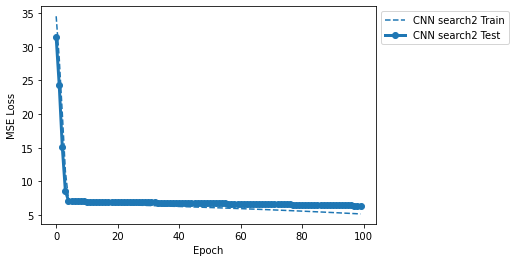

In [94]:
quick_loss_plot_simple(search_label2)

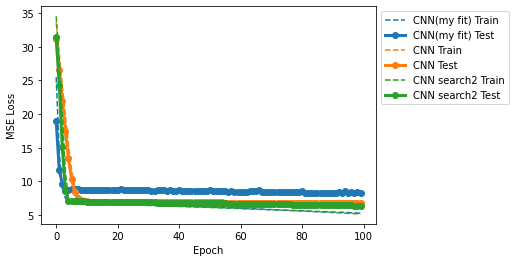

In [95]:
quick_loss_plot_simple(cnn_data_labeldata_labeldata_label+ search_label+search_label2)

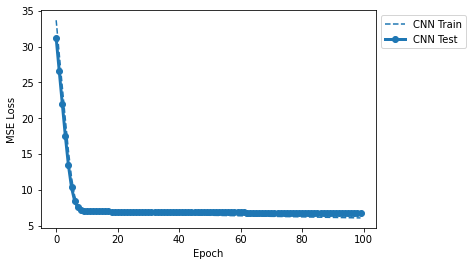

In [36]:
quick_loss_plot_simple(search_label)

In [121]:
res_df = pd.DataFrame(search.cv_results_)
res_df['opt_name'] = res_df['param_optimizer'].apply(lambda x: x.__name__)
res_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr,param_module__kernel_size,param_module__num_fc_nodes1,param_module__num_filters,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,opt_name
0,8.425165,0.272247,0.011698,0.000779,0.000068,4,10,128,<class 'torch.optim.adam.Adam'>,"{'lr': 6.824078427098832e-05, 'module__kernel_...",-8.488585,-9.098982,-9.689571,-9.092380,0.490323,295,Adam
1,7.609876,0.384612,0.011346,0.000451,0.00004,32,10,16,<class 'torch.optim.adam.Adam'>,"{'lr': 4.024066464714609e-05, 'module__kernel_...",-5.982431,-6.580366,-8.026361,-6.863053,0.858039,76,Adam
2,6.731470,1.938558,0.011934,0.000879,0.000024,8,10,64,<class 'torch.optim.adam.Adam'>,"{'lr': 2.357873072646738e-05, 'module__kernel_...",-5.892961,-6.547549,-7.964107,-6.801539,0.864405,14,Adam
3,3.837126,0.292347,0.013035,0.001248,0.00012,16,25,64,<class 'torch.optim.rmsprop.RMSprop'>,"{'lr': 0.00011957309429716364, 'module__kernel...",-15.343936,-13.417123,-14.529415,-14.430158,0.789743,385,RMSprop
4,3.714270,0.290185,0.012389,0.000958,0.000026,16,10,32,<class 'torch.optim.adagrad.Adagrad'>,"{'lr': 2.563920173316309e-05, 'module__kernel_...",-19.880381,-24.158636,-21.253864,-21.764294,1.783493,475,Adagrad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,5.986337,0.038526,0.015241,0.002368,0.000056,16,50,128,<class 'torch.optim.adamw.AdamW'>,"{'lr': 5.635354393219453e-05, 'module__kernel_...",-11.693987,-10.634693,-11.601083,-11.309921,0.478962,347,AdamW
496,4.308753,0.291755,0.012411,0.001041,0.000079,4,100,16,<class 'torch.optim.adamw.AdamW'>,"{'lr': 7.862225984172072e-05, 'module__kernel_...",-7.704754,-8.891400,-9.661625,-8.752593,0.804896,277,AdamW
497,3.639159,0.024466,0.010665,0.000097,0.000346,16,100,16,<class 'torch.optim.adam.Adam'>,"{'lr': 0.0003462565933685947, 'module__kernel_...",-19.566202,-16.977901,-17.139002,-17.894368,1.183993,436,Adam
498,4.648105,0.477695,0.012832,0.001219,0.00001,16,50,32,<class 'torch.optim.adam.Adam'>,"{'lr': 1.0372417807224561e-05, 'module__kernel...",-6.104016,-6.593068,-8.060892,-6.919325,0.831534,141,Adam


In [122]:
sm_res_df = res_df[["rank_test_score","mean_test_score","param_module__num_filters","param_module__kernel_size","param_lr","param_module__num_fc_nodes1","opt_name"]]

In [119]:
a = res_df['param_optimizer'].values[0]
a.__name__

'Adam'

In [130]:
alt.Chart(sm_res_df).mark_point().encode(
    x='rank_test_score:Q',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:Q',scale=alt.Scale(scheme='viridis')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N"
    
).interactive()

alt.Chart(...)

In [48]:
# old search
alt.Chart(res_df).mark_point().encode(
    x='rank_test_score:Q',
    y='mean_test_score:Q',
    color='param_module__num_filters:N',
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    shape="param_lr:N"
    
).interactive()

alt.Chart(...)

In [131]:
alt.Chart(sm_res_df).mark_point().encode(
    x='param_module__num_filters:O',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:Q',scale=alt.Scale(scheme='viridis')),
    column='opt_name:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N",
    tooltip=["param_module__num_filters:N","param_module__kernel_size:N","param_lr:N","param_module__num_fc_nodes1:N"]
    
).interactive()

alt.Chart(...)

In [49]:
alt.Chart(res_df).mark_point().encode(
    x='param_module__num_filters:O',
    y='mean_test_score:Q',
    color='param_module__num_fc_nodes1:N',
    column='param_module__kernel_size:N',
#     detail='model_desc:N',
    shape="param_lr:N",
    tooltip=["param_module__num_filters:N","param_module__kernel_size:N","param_lr:N","param_module__num_fc_nodes1:N"]
    
).interactive()

alt.Chart(...)

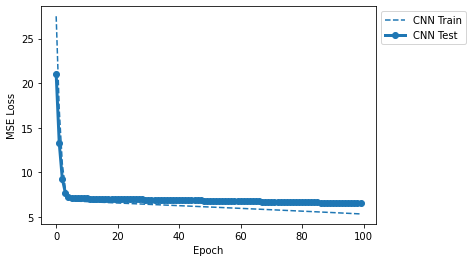

In [126]:
quick_loss_plot_simple(search_label)

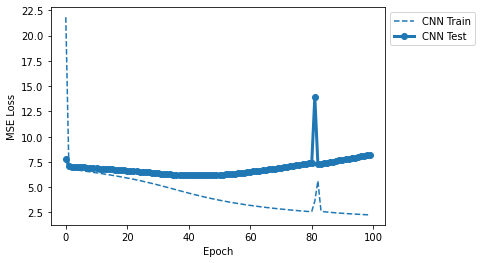

In [102]:
quick_loss_plot_simple(skorch_label)

In [129]:
search.cv_results_

{'mean_fit_time': array([7.01088428, 4.42818109, 3.42834489, 3.95703506, 3.03712384,
        3.20101452, 3.71479185, 4.5880541 , 3.09035261, 3.45978928,
        4.44256012, 6.00824229, 3.08462516, 3.10210633, 3.42395616,
        4.02246253, 3.06266077, 3.22416051, 3.74238586, 4.71368575,
        3.13223863, 3.43420053, 4.50079807, 5.94328046, 3.1670169 ,
        3.09290139, 3.45399404, 4.0903279 , 3.09330328, 3.19306374,
        3.74253345, 4.73407292, 3.20855832, 3.44187307, 4.47750322,
        6.02262719, 3.297544  , 3.11545897, 3.38717922, 3.92896573,
        3.14759533, 3.17649436, 3.6461819 , 4.54853042, 3.26868145,
        3.41961376, 4.47028526, 5.83333262, 3.36724361, 3.07715821,
        3.38571866, 3.98005795, 3.18610668, 3.1757439 , 3.67576528,
        4.58222818, 3.34459837, 3.43135699, 4.43138488, 5.84409332,
        3.50341439, 3.09344514, 3.45419073, 4.02507281, 3.22028303,
        3.18748426, 3.696721  , 4.64363424, 3.43957615, 3.39142656,
        4.49606482, 5.44134967]

In [130]:
results = pd.DataFrame(search.cv_results_)

In [134]:
results[['params','mean_test_score','rank_test_score']].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
51,"{'module__num_filters': 128, 'module__num_fc_n...",-6.785219,1
55,"{'module__num_filters': 128, 'module__num_fc_n...",-6.817742,2
67,"{'module__num_filters': 128, 'module__num_fc_n...",-6.821124,3
50,"{'module__num_filters': 64, 'module__num_fc_no...",-6.821130,4
71,"{'module__num_filters': 128, 'module__num_fc_n...",-6.822330,5
...,...,...,...
19,"{'module__num_filters': 128, 'module__num_fc_n...",-11.241606,68
23,"{'module__num_filters': 128, 'module__num_fc_n...",-11.359755,69
31,"{'module__num_filters': 128, 'module__num_fc_n...",-11.716529,70
35,"{'module__num_filters': 128, 'module__num_fc_n...",-11.768762,71


In [170]:
ypred = search.best_estimator_.predict(X)
pearson = np.corrcoef(np.array(y).flatten(),ypred.flatten())
p2 = scipy.stats.pearsonr(np.array(y).flatten(),ypred.flatten())

In [172]:
p2[0]

0.5763646985601483

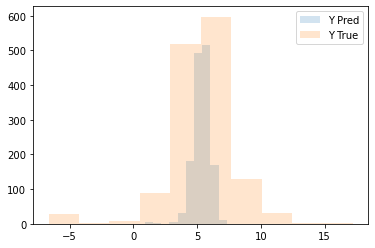

In [158]:
plt.hist(ypred,alpha=0.2, label="Y Pred")
plt.hist(np.array(y),alpha=0.2, label="Y True")
plt.legend()
plt.show()

(array([ 27.,   2.,   9.,  89., 518., 597., 130.,  32.,   3.,   3.]),
 array([-6.643856 , -4.2568126, -1.8697689,  0.5172747,  2.9043183,
         5.291362 ,  7.6784053, 10.065449 , 12.452493 , 14.839536 ,
        17.22658  ], dtype=float32),
 <BarContainer object of 10 artists>)

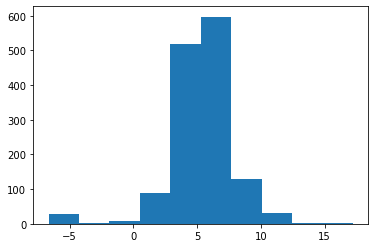

In [150]:
plt.hist(np.array(y))

In [159]:
pearson

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

ok, i think I'm seeing how to use skorch to automatically search through hyperparams...
* maybe visualize which types of params were better?
* series of distributions
* can I also change the optimizer? all the other parts I want to vary?
* then try with multitask?

In [176]:
def parity_plot(model,ytrue,ypred, pearson):
    plt.scatter(ytrue, ypred, alpha=0.2)
    
    # y=x line
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)

    plt.xlabel("Actual Score",fontsize=14)
    plt.ylabel("Predicted Score",fontsize=14)
    plt.title(f"{model} (pearson:{pearson:.3f})",fontsize=20)
    plt.show()

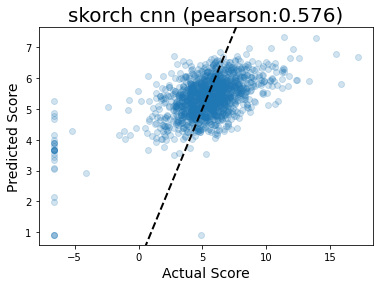

In [177]:
parity_plot("skorch cnn train", y, ypred,p2[0])

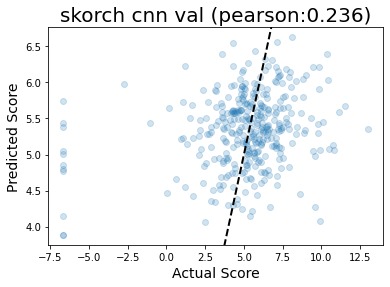

In [179]:
Xval, yval = make_skorch_dfs(log_val_df, seq_col='upstream_region',target_col='highCu')
ypred_val = search.best_estimator_.predict(Xval)

pearson_val = scipy.stats.pearsonr(np.array(yval).flatten(),ypred_val.flatten())

parity_plot("skorch cnn val", yval, ypred_val,pearson_val[0])

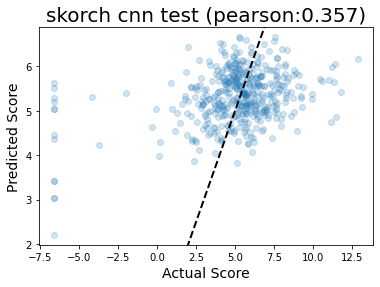

In [180]:
Xtest, ytest = make_skorch_dfs(log_test_df, seq_col='upstream_region',target_col='highCu')
ypred_test = search.best_estimator_.predict(Xtest)

pearson_test = scipy.stats.pearsonr(np.array(ytest).flatten(),ypred_test.flatten())

parity_plot("skorch cnn test", ytest, ypred_test,pearson_test[0])

In [206]:
b = search.best_estimator_

In [228]:
for i in b.module_.children():
    if type(i) == nn.Sequential:
        for child in i:
            if type(child) == nn.Conv2d:
                print(child.weight)

Parameter containing:
tensor([[[[-0.0081, -0.0627, -0.1479,  ...,  0.0843, -0.0111, -0.1269],
          [ 0.0527,  0.0613,  0.1436,  ...,  0.1626,  0.1311,  0.0936],
          [ 0.1750, -0.1044,  0.0645,  ...,  0.0217, -0.1659,  0.0794],
          [-0.0444, -0.1172, -0.1364,  ...,  0.0680, -0.0012, -0.0140]]],


        [[[-0.1494, -0.1347, -0.1770,  ...,  0.1067,  0.1489,  0.0382],
          [ 0.0236,  0.0780,  0.0103,  ...,  0.0788, -0.0260,  0.1464],
          [ 0.0025,  0.1143,  0.0005,  ...,  0.0918, -0.1471,  0.0753],
          [-0.1185,  0.0852,  0.1201,  ..., -0.0284,  0.1383, -0.1516]]],


        [[[-0.1012, -0.0443, -0.1722,  ..., -0.0240, -0.1000, -0.1336],
          [ 0.0094, -0.1417, -0.1268,  ..., -0.1390,  0.0377,  0.1030],
          [ 0.0641, -0.0039, -0.0614,  ...,  0.1516,  0.1134,  0.1449],
          [-0.0312,  0.0593,  0.0820,  ...,  0.0222, -0.1358, -0.1188]]],


        ...,


        [[[ 0.1741,  0.0341, -0.0067,  ...,  0.1688,  0.0245,  0.0159],
          [ 0.0

In [197]:
b.score(Xval,yval)

0.04798809513781832

# Run skorch with a Pytorch data loader

In [202]:
net_dl = NeuralNetRegressor(
    DNA_CNN,
    module__seq_len=300,
    max_epochs=100,
    #lr=0.001,
    device='cuda',  # uncomment this to train with CUDA
    iterator_train = log_ohe_train_dl,
    iterator_valid = log_ohe_val_dl
)

In [203]:
search_dl = RandomizedSearchCV(
    net_dl, 
    params, 
    n_iter=200, 
    #scoring='neg_mean_absolute_error', 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    cv=3,#cv, 
    random_state=1,
    verbose=2
)

In [204]:
search_dl.fit(X, y)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 302 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   30.0s finished


TypeError: 'DataLoader' object is not callable

The FAQ seems to say to NOT provide a Dataset if possible - skorch does Dataloader stuff under the hood? 

"skorch supports datasets as input but sklearn doesn’t. If it’s possible, you should provide your data in a non-dataset format, e.g. as a numpy array or torch tensor, extracted from your original dataset."
https://skorch.readthedocs.io/en/stable/user/FAQ.html#faq-how-do-i-use-a-pytorch-dataset-with-skorch

# Run Skorch with MT model

In [229]:
class DNA_CNN_Multi(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=5,
                 num_fc_nodes1=100,
                 num_fc_nodes2=10
                ):
        super().__init__()
        self.seq_len = seq_len
        self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            #nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(self.lin_nodes, num_fc_nodes1),
            nn.Linear(num_fc_nodes1, num_fc_nodes2),
        )
        # define the multi task objectives?
        self.obj0   = nn.Linear(num_fc_nodes2,1)
        self.obj1   = nn.Linear(num_fc_nodes2,1)
        self.obj2   = nn.Linear(num_fc_nodes2,1)
        self.obj3   = nn.Linear(num_fc_nodes2,1)
        self.obj4   = nn.Linear(num_fc_nodes2,1)
        self.obj5   = nn.Linear(num_fc_nodes2,1)
        self.obj6   = nn.Linear(num_fc_nodes2,1)
        self.obj7   = nn.Linear(num_fc_nodes2,1)
        self.obj8   = nn.Linear(num_fc_nodes2,1)
        self.obj9   = nn.Linear(num_fc_nodes2,1)
        self.obj10  = nn.Linear(num_fc_nodes2,1)
        self.obj11  = nn.Linear(num_fc_nodes2,1)
        

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        
        out = self.conv_net(xb)
        
        out0 = self.obj0(out)
        out1 = self.obj1(out)
        out2 = self.obj2(out)
        out3 = self.obj3(out)
        out4 = self.obj4(out)
        out5 = self.obj5(out)
        out6 = self.obj6(out)
        out7 = self.obj7(out)
        out8 = self.obj8(out)
        out9 = self.obj9(out)
        out10 = self.obj10(out)
        out11 = self.obj11(out)
        
        all_outs = [out0,out1,out2,out3,out4,out5,out6,out7,out8,out9,out10,out11]
        
        return all_outs

In [233]:
condition_file = 'data/conditions_to_include.txt'
with open(condition_file,'r') as f:
    conditions = list(x.strip() for x in f.readlines())
    
cond_dict = dict(enumerate(conditions))
cond_dict

{0: 'uMax',
 1: 'lowO2_fast_growth',
 2: 'lowCH4',
 3: 'MeOH',
 4: 'NoCu',
 5: 'medCu',
 6: 'highCu',
 7: 'lowCu',
 8: 'highO2_slow_growth',
 9: 'NO3_lowO2_slow_growth',
 10: 'WithLanthanum',
 11: 'NoLanthanum'}

In [ ]:
def make_multi_skorch_dfs(df,seq_col='seq',target_cols=conditions):
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
    
    return ohe_seqs.float(), labels.float()